In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
% matplotlib inline

In [2]:
dataTrain = np.loadtxt('./data/EMGaussian.data')
dataTest = np.loadtxt('./data/EMGaussian.test')

In [3]:
print("Train data:",  np.size(dataTrain[:, 0]),  "points")
print("Test data:", np.size(dataTest[:,0]), "points")

Train data: 500 points
Test data: 500 points


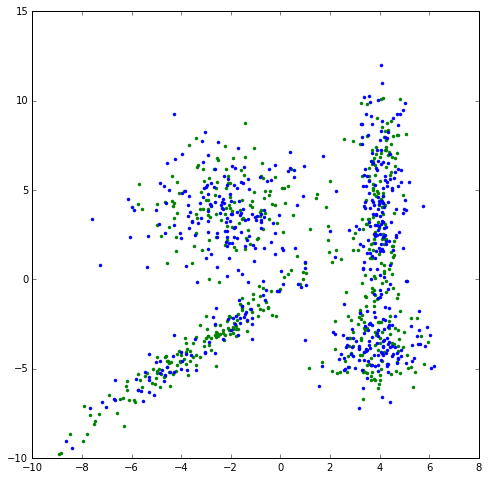

In [4]:
plt.figure(figsize=(8,8))
plt.plot(dataTrain[:, 0],dataTrain[:, 1], 'g.')
plt.plot(dataTest[:, 0],dataTest[:, 1], 'b.')

In [5]:
def designMatrixPreproc(X): #centering and normalizing the Nx2 design matrix X
    meanX = np.mean(X,axis=0)
    Xcent = X - meanX
    stdX = np.std(Xcent, axis=0)
    newX = Xcent/stdX
    return newX

In [6]:
dataTrain = designMatrixPreproc(dataTrain)
dataTest = designMatrixPreproc(dataTest)


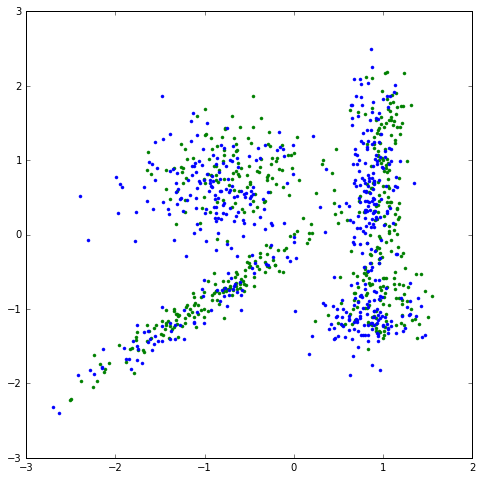

In [7]:
plt.figure(figsize=(8,8))
plt.plot(dataTrain[:, 0],dataTrain[:, 1], 'g.')
plt.plot(dataTest[:, 0],dataTest[:, 1], 'b.')

In [8]:
def distortion(X, mu, z):
    #compute the distortion, z is the cluster assignment vector, ie z[i] = k if point i is assigned to cluster k
    J = 0
    for i in range(np.size(X[:,0])):
        J = J + np.linalg.norm(X[i] - mu[z[i]])**2
    return J    

def kmeans(X, K):
    N = np.size(X[:,0])
    mu = np.zeros((K, 2))
    z = np.random.randint(K, size=N)
    #Intitialize the centers
    for k in range(K):
            mu[k,:] = X[np.random.randint(N)]
    J = distortion(X, mu, z)
    Jold = float('inf')
    while (J<Jold):
        Jold = J
        for i in range(N):
            dist = float('inf')
            for k in range(K):
                tmp = np.linalg.norm(X[i] - mu[k])
                if tmp < dist:
                    z[i] = k
                    dist = tmp
        for k in range(K):
            mu[k,:] = np.mean(X[z==k], axis=0)
        J = distortion(X, mu, z)
    return mu, z, J

In [9]:
mu, zTrain, Jtrain = kmeans(dataTrain, 4)

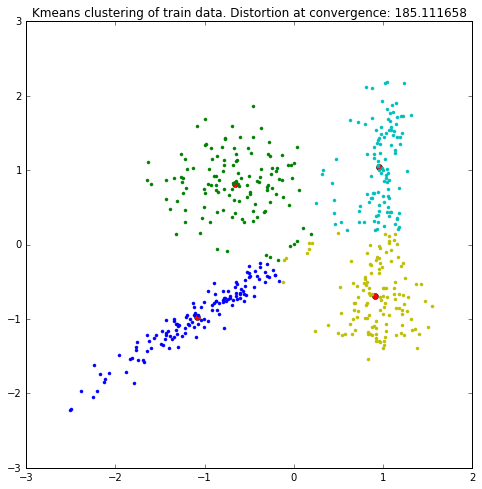

In [10]:
plt.figure(figsize=(8,8))
plt.plot(mu[:,0], mu[:,1], 'ro')
cluster1 = dataTrain [zTrain==0]
plt.plot(cluster1[:, 0],cluster1[:, 1], 'g.')

cluster2 = dataTrain [zTrain==1]
plt.plot(cluster2[:, 0],cluster2[:, 1], 'b.')

cluster3 = dataTrain [zTrain==2]
plt.plot(cluster3[:, 0],cluster3[:, 1], 'y.')

cluster4 = dataTrain [zTrain==3]
plt.plot(cluster4[:, 0],cluster4[:, 1], 'c.')

s = 'Kmeans clustering of train data. Distortion at convergence: %f' % (Jtrain)

plt.title(s)

In [11]:
def cov(X, mu, tau): 
    #computes the covariance based on the Nx1 tau (for the considered gaussian component), the 1x2 center vector mu the Nx2 matrix X
    num = 0.
    den = 0.
    for i in range(np.size(X[:,0])):
        tmp = X[i]-mu
        num = num + tau[i]*(np.dot(tmp, tmp))
        den = den + tau[i]
    return (num/den)

def normalIso(x, mu, sigma2):
    #returns the image of x by the isotropic normal function of mean mu and covariance sigma2
    scal = -0.5*(np.dot([x-mu], np.transpose([x-mu])))[0][0]/sigma2
    return (np.exp(scal)/(2*math.pi*math.sqrt(sigma2)))

In [12]:
def EM(X, K):
    N = np.size(X[:,0])
    mu, z = kmeans(X, K)[0:2]
    tau = np.array([np.array(z == k, dtype='float') for k in range(K)]) #tau is KxN
    pi = np.array([np.size(z[z == k]) for k in range(K)])/N #the fraction of data in each cluster according to Kmeans
    sigma2 = np.zeros(K)
    for k in range(K):
        sigma2[k] = np.sum([tau[k,i]*np.dot(X[i]-mu[k], X[i] - mu[k]) for i in range(N)], 0)/(2*N*pi[k]) 
        #the scalar covariance of each kemans cluster
    for t in range(10): 
        #E-step
        tmp = np.array([[pi[k]*normalIso(X[i], mu[k], sigma2[k]) for i in range(N)] for k in range(K)])
        tau = tmp
        tmp = np.sum(tau,0)
        tau = np.array([[tau[k, i]/tmp[i] for i in range(N)] for k in range(K)])
        #M-step
        pi = np.mean(tau, 1)
        for k in range(K):
            mu[k] = np.sum([tau[k,i]*X[i] for i in range(N)], 0)/(N*pi[k])
            sigma2[k] = np.sum([tau[k,i]*np.dot(X[i]-mu[k], X[i] - mu[k]) for i in range(N)], 0)/(2*N*pi[k])
    return pi, mu, sigma2, tau
    

In [13]:
piEM, muEM, sigma2EM, tauEM = EM(dataTrain, 4)
zTrainEM = np.argmax(tauEM, 0)

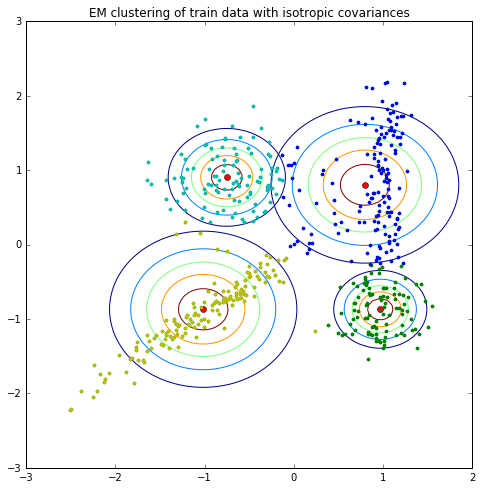

In [14]:
plt.figure(figsize=(8,8))
plt.plot(dataTrain[:, 0],dataTrain[:, 1], 'g.')
plt.plot(muEM[:,0], muEM[:,1], 'ro')

cluster1 = dataTrain [zTrainEM==0]
plt.plot(cluster1[:, 0],cluster1[:, 1], 'g.')

cluster2 = dataTrain [zTrainEM==1]
plt.plot(cluster2[:, 0],cluster2[:, 1], 'b.')

cluster3 = dataTrain [zTrainEM==2]
plt.plot(cluster3[:, 0],cluster3[:, 1], 'y.')

cluster4 = dataTrain [zTrainEM==3]
plt.plot(cluster4[:, 0],cluster4[:, 1], 'c.')

xgrid , ygrid = np.meshgrid(np.linspace(-3,2, 100),np.linspace(-3,3, 100))


zgrid = np.array([[normalIso([xgrid[i, j], ygrid[i ,j]], muEM[2], sigma2EM[2]) for j in range(len(xgrid))] for i in range(len(xgrid))], dtype='float64')
plt.contour(xgrid,ygrid,zgrid,5)

zgrid = np.array([[normalIso([xgrid[i, j], ygrid[i ,j]], muEM[0], sigma2EM[0]) for j in range(len(xgrid))] for i in range(len(xgrid))], dtype='float64')
plt.contour(xgrid,ygrid,zgrid,5)

zgrid = np.array([[normalIso([xgrid[i, j], ygrid[i ,j]], muEM[1], sigma2EM[1]) for j in range(len(xgrid))] for i in range(len(xgrid))], dtype='float64')
plt.contour(xgrid,ygrid,zgrid,5)

zgrid = np.array([[normalIso([xgrid[i, j], ygrid[i ,j]], muEM[3], sigma2EM[3]) for j in range(len(xgrid))] for i in range(len(xgrid))], dtype='float64')
plt.contour(xgrid,ygrid,zgrid,5)

plt.title("EM clustering of train data with isotropic covariances")


#### EM with General Covariances

In [15]:
def normal(x, mu, sigma):
    #returns the image of x by the normal function of mean mu and covariance sigma
    scal = (np.dot(np.dot([x-mu], np.linalg.inv(sigma)), np.transpose([x-mu])))[0][0]
    return (np.exp(-scal/2.)/math.sqrt(2*math.pi*np.linalg.det(sigma)))

In [16]:
def EMgen(X, K):
    N = np.size(X[:,0])
    mu, z = kmeans(X, K)[0:2]
    tau = np.array([np.array(z == k, dtype='float') for k in range(K)]) #tau is KxN
    pi = np.array([np.size(z[z == k]) for k in range(K)])/N #the fraction of data in each cluster according to Kmeans
    sigma = np.zeros((K,2,2))
    for k in range(K):
        sigma[k] = np.sum([tau[k,i]*np.dot(np.transpose([X[i]-mu[k]]), [X[i] - mu[k]]) for i in range(N)], 0)/(N*pi[k]) 
        #the scalar covariance of each kemans cluster
    for t in range(10): 
        #E-step
        tmp = np.array([[pi[k]*normal(X[i], mu[k], sigma[k]) for i in range(N)] for k in range(K)])
        tau = tmp
        tmp = np.sum(tau,0)
        tau = np.array([[tau[k, i]/tmp[i] for i in range(N)] for k in range(K)])
        #M-step
        pi = np.mean(tau, 1)
        for k in range(K):
            mu[k] = np.sum([tau[k,i]*X[i] for i in range(N)], 0)/(N*pi[k])
            sigma[k] = np.sum([tau[k,i]*np.dot(np.transpose([X[i]-mu[k]]), [X[i] - mu[k]]) for i in range(N)], 0)/(N*pi[k])
    return pi, mu, sigma, tau

In [17]:
piEMgen, muEMgen, sigmaEMgen, tauEMgen = EMgen(dataTrain, 4)
zTrainEMgen = np.argmax(tauEMgen, 0)

In [28]:
np.save('../Homework3/muHWK2', muEMgen)
np.save('../Homework3/sigmaHWK2', sigmaEMgen)

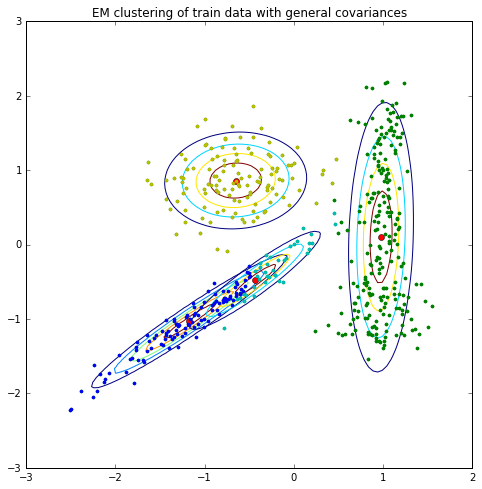

In [18]:
plt.figure(figsize=(8,8))
plt.plot(dataTrain[:, 0],dataTrain[:, 1], 'g.')
plt.plot(muEMgen[:,0], muEMgen[:,1], 'ro')

cluster1 = dataTrain [zTrainEMgen==0]
plt.plot(cluster1[:, 0],cluster1[:, 1], 'g.')

cluster2 = dataTrain [zTrainEMgen==1]
plt.plot(cluster2[:, 0],cluster2[:, 1], 'b.')

cluster3 = dataTrain [zTrainEMgen==2]
plt.plot(cluster3[:, 0],cluster3[:, 1], 'y.')

cluster4 = dataTrain [zTrainEMgen==3]
plt.plot(cluster4[:, 0],cluster4[:, 1], 'c.')

xgrid , ygrid = np.meshgrid(np.linspace(-3,2, 100),np.linspace(-3,3, 100))


zgrid = np.array([[normal([xgrid[i, j], ygrid[i ,j]], muEMgen[2], sigmaEMgen[2]) for j in range(len(xgrid))] for i in range(len(xgrid))], dtype='float64')
plt.contour(xgrid,ygrid,zgrid,5)

zgrid = np.array([[normal([xgrid[i, j], ygrid[i ,j]], muEMgen[0], sigmaEMgen[0]) for j in range(len(xgrid))] for i in range(len(xgrid))], dtype='float64')
plt.contour(xgrid,ygrid,zgrid,5)

zgrid = np.array([[normal([xgrid[i, j], ygrid[i ,j]], muEMgen[1], sigmaEMgen[1]) for j in range(len(xgrid))] for i in range(len(xgrid))], dtype='float64')
plt.contour(xgrid,ygrid,zgrid,5)

zgrid = np.array([[normal([xgrid[i, j], ygrid[i ,j]], muEMgen[3], sigmaEMgen[3]) for j in range(len(xgrid))] for i in range(len(xgrid))], dtype='float64')
plt.contour(xgrid,ygrid,zgrid,5)

plt.title("EM clustering of train data with general covariances")

#### Comparison

In [19]:
def logLikelihood(X, mu, sigma, pi):
    N = np.size(X[:, 0])
    K = np.size(pi)
    if (np.size(sigma) == 2*2*K):
        tmp = np.array([[pi[k]*normal(X[i], mu[k], sigma[k]) for i in range(N)] for k in range(K)])
    else:
        tmp = np.array([[pi[k]*normalIso(X[i], mu[k], sigma[k]) for i in range(N)] for k in range(K)])
    res = np.sum(tmp, 0)
    return np.sum([math.log(x) for x in res])


In [20]:
logLikelihood(dataTrain, muEM, sigma2EM, piEM)

-1615.647439995239

In [21]:
logLikelihood(dataTest, muEM, sigma2EM, piEM)

-1707.6895006071788

In [22]:
logLikelihood(dataTrain, muEMgen, sigmaEMgen, piEMgen)

-519.40164846393282

In [23]:
logLikelihood(dataTest, muEMgen, sigmaEMgen, piEMgen)

-770.08319219599878